# Exploration of 2023 Annotations


* Data annotated by Simon Geikie July/August 2023
* Data sourced for Ordnance Survey July/August 2023

| **Key**                     | **Meaning**                                                             |
|-----------------------------|-------------------------------------------------------------------------|
| Present (2023)           | Present in OS data \| Present in the 2023 AP \| Present in 2014 AP      |
| Absent (2023)            | Present in OS data \| Absent in the 2023 AP \| Absent in 2014 AP        |
| Absent (Present 2014)    | Absent in OS data \| Absent in the 2023 AP \| Present in 2014 AP        |
| Obscured (shadows and vegetation)    | Obscured by trees, scrub or long grass.                                 |
| Urban                    | A mask created to simplify the detection of walls to only the open landscape |
| Absent (Present 1950)    | Absent in OS data \| Present only on 1950's basemap                     |

In [37]:
# load libraries 
import geopandas as gpd
from centerline.geometry import Centerline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from shapely.geometry import Polygon, LineString, MultiLineString, Point, GeometryCollection
from shapely.ops import unary_union
import fiona
import h3
import h3pandas

In [4]:
# load data
walls = gpd.read_file("../content/labels/Walls.shp")

<AxesSubplot:>

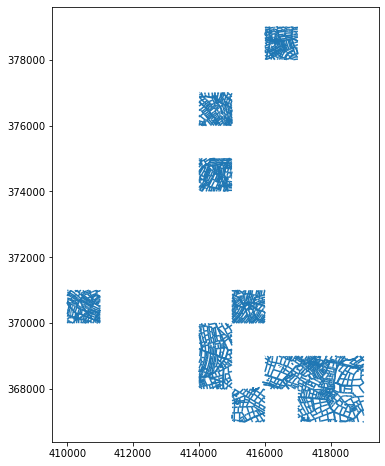

In [34]:
# take a look
walls.plot(figsize=(8,8))

In [35]:
walls.head(1)

,osid,toid,Label_2023,theme,istidal,changetype,ishistoric,isobscured,descriptio,versiondat,...,capturespe,geometry_e,descript_2,versionava,firstdigit,descript_3,versiona_1,FID_1,Shape_Leng,geometry
0,d4e434d7-ab01-49d6-af83-d747e155abae,osgb5000005154743092,Urban,Structures,0.0,New,0.0,0.0,Built Obstruction,2022-08-26,...,Rural,2014-07-24,2015-04-17,None,2015-04-17,2014-07-24,2022-08-27T00:00:00Z,0.0,0.666023,"LINESTRING (415354.513 367005.429, 415354.887 ..."


In [36]:
walls['Label_2023'].unique()

array(['Urban', 'Present (2023)', 'Obscured (shadows and vegetation)',
       'Absent (2023)', 'Absent (Present 2014)', 'Absent (Present 1950)'],
      dtype=object)

In [37]:
walls['length'] = walls.length

In [42]:
wall_t = pd.pivot_table(walls, columns='Label_2023', values='length', aggfunc=np.sum)
wall_t = wall_t.T.reset_index()
wall_t

C:\Users\alexad\AppData\Local\Temp\ipykernel_11500\3379901016.py:1: FutureWarning: The provided callable <function sum at 0x0000020C2BB40C10> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  wall_t = pd.pivot_table(walls, columns='Label_2023', values='length', aggfunc=np.sum)


,Label_2023,length
0,Absent (2023),1775.155251
1,Absent (Present 1950),33302.576547
2,Absent (Present 2014),1950.483098
3,Obscured (shadows and vegetation),40182.210978
4,Present (2023),202160.536977
5,Urban,44043.508570


In [43]:
data = ['Absent', 'Absent', 'Absent', 'Present', 'Present', 'Urban' ]
wall_t['presence'] = data
wall_t

,Label_2023,length,presence
0,Absent (2023),1775.155251,Absent
1,Absent (Present 1950),33302.576547,Absent
2,Absent (Present 2014),1950.483098,Absent
3,Obscured (shadows and vegetation),40182.210978,Present
4,Present (2023),202160.536977,Present
5,Urban,44043.508570,Urban


In [44]:
# for graph only
wall_t = wall_t.drop(index=(5))
pivot = pd.pivot_table(data=wall_t, index=['presence'], columns=['Label_2023'], values='length')

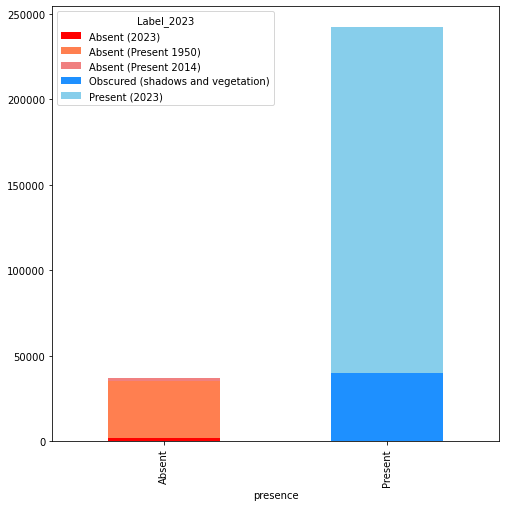

In [66]:
color = ['red', 'coral', 'lightcoral', 'dodgerblue', 'skyblue']
ax = pivot.plot.bar(stacked=True, figsize=(8,8), color=color)

# Exploration of Predictions

In [2]:
# Load the original and clipping shapefiles
os = gpd.read_file("../QGIS/PDNP_fieldboundary/os-intersect-clip.shp") # from intersection in GIS
# clip the data buffer and save
os = os.buffer(10)
# Use unary_union to dissolve all features into one geometry
os = unary_union(os)
# Create a new GeoDataFrame with the dissolved geometry
os = gpd.GeoDataFrame(geometry=[os], crs="EPSG:27700")
# save to file
os.to_file("../content/1950-corridors/2024-corridors.shp")


In [44]:
#mask = gpd.read_file('../QGIS/masks/combined-mask.shp')
oldcorridors = gpd.read_file("../content/1950-corridors/1950-corridors.shp")
newcorridors = gpd.read_file("../content/1950-corridors/2024-corridors.shp")


In [5]:
def calculate_estimated_length(buffered_gdf, buffer_width_each_side):
    # Calculate the total perimeter of the buffered polygons
    total_perimeter = buffered_gdf.geometry.length.sum()
    
    # Estimate the total length of the original linear features
    # Assuming the buffer was applied equally on both sides
    estimated_total_length = (total_perimeter / 2) - (buffer_width_each_side * 2 * len(buffered_gdf))
    
    return estimated_total_length

def print_estimated_lengths_and_differences(oldcorridors, newcorridors, buffer_width_each_side):
    old_estimated_length = calculate_estimated_length(oldcorridors, buffer_width_each_side)
    new_estimated_length = calculate_estimated_length(newcorridors, buffer_width_each_side)
    
    # Convert meters to kilometers
    old_estimated_length_km = old_estimated_length / 1000
    new_estimated_length_km = new_estimated_length / 1000
    
    # Calculate differences and percentage change
    difference = old_estimated_length - new_estimated_length
    difference_km = difference / 1000
    percent_change = (difference / old_estimated_length) * 100 if old_estimated_length else 0
    
    # Print results
    print(f"Estimated total length of original linear features in old corridors: {old_estimated_length} meters ({old_estimated_length_km:.2f} km)")
    print(f"Estimated total length of original linear features in new corridors: {new_estimated_length} meters ({new_estimated_length_km:.2f} km)")
    print(f"Difference (old - new): {difference} meters ({difference_km:.2f} km)")
    print(f"Percentage change: {percent_change:.2f}%")

# Assuming buffer_width_each_side is 10 meters on each side of the original line
buffer_width_each_side = 10

# Print estimated lengths and differences
print_estimated_lengths_and_differences(oldcorridors, newcorridors, buffer_width_each_side)


Estimated total length of original linear features in old corridors: 4693463.213308696 meters (4693.46 km)
Estimated total length of original linear features in new corridors: 3917797.1292161625 meters (3917.80 km)
Difference (old - new): 775666.0840925332 meters (775.67 km)
Percentage change: 16.53%


#### Lets MAP

In [54]:
# Function to calculate the estimated length for each grid cell
def calculate_estimated_length_within_grid(grid_cell, corridors_gdf, buffer_width_each_side):
    # Clip the corridors to the boundary of the grid cell
    clipped_lines = gpd.clip(corridors_gdf, grid_cell.geometry)
    
    # Calculate the total length of the clipped lines within the grid cell
    total_perimeter = clipped_lines.length.sum()
    
    # Calculate the estimated original length, adjusting for the buffer width
    estimated_total_length = (total_perimeter / 2) - (buffer_width_each_side * 2 * len(clipped_lines))
    
    return estimated_total_length

# Function to calculate and append lengths to the grid
def append_lengths_to_grid(osgrid, oldcorridors, newcorridors, buffer_width_each_side):
    osgrid['old_len'] = osgrid.apply(lambda row: calculate_estimated_length_within_grid(row, oldcorridors, buffer_width_each_side), axis=1)
    osgrid['new_len'] = osgrid.apply(lambda row: calculate_estimated_length_within_grid(row, newcorridors, buffer_width_each_side), axis=1)

# Assuming buffer_width_each_side is 10 meters on each side of the original line
buffer_width_each_side = 10

# Load the grid and the corridors GeoDataFrames
osgrid = gpd.read_file("../content/landscape_character_grid/selection_white_peak.shp")
oldcorridors = gpd.read_file("../content/1950-corridors/1950-corridors.shp")
newcorridors = gpd.read_file("../content/1950-corridors/2024-corridors.shp")

# Append the lengths to the grid
append_lengths_to_grid(osgrid, oldcorridors, newcorridors, buffer_width_each_side)

# Now `osgrid` contains `old_len` and `new_len` columns with the calculated lengths
# You can save this updated grid to a new file or use it for further analysis/visualization
osgrid.to_file("../content/1950-corridors/osgrid_with_lengths.shp")


In [45]:
# check its worked
df = gpd.read_file(("../content/1950-corridors/osgrid_with_lengths.shp"))
# Add 'diff_len' column as the difference between 'new_len' and 'old_len'
df['diff_len'] = df['new_len'] - df['old_len']

# Add 'perc_diff' column showing the percentage difference for each grid square
df['perc_diff'] = ((df['new_len'] - df['old_len']) / df['old_len'] * 100).fillna(0)

# Convert lengths from meters to kilometers for individual grid squares
df['old_len_km'] = df['old_len'] / 1000
df['new_len_km'] = df['new_len'] / 1000
df['diff_len_km'] = df['diff_len'] / 1000

# Calculate the sum of 'old_len', 'new_len', and 'diff_len' in kilometers for overall statistics
total_old_len_km = df['old_len_km'].sum()
total_new_len_km = df['new_len_km'].sum()
total_diff_len_km = df['diff_len_km'].sum()

# Calculate average percentage change
average_perc_diff = df['perc_diff'].mean()

# Print the results in kilometers and percentage
print(f"Total Old Length: {total_old_len_km:.2f} km")
print(f"Total New Length: {total_new_len_km:.2f} km")
print(f"Total Length Difference: {total_diff_len_km:.2f} km")
print(f"Average Percentage Difference: {average_perc_diff:.2f}%")

# Optional: Save the modified GeoDataFrame with new columns
df.to_file("../content/1950-corridors/osgrid_with_lengths.shp")

Total Old Length: 4834.25 km
Total New Length: 4035.61 km
Total Length Difference: -798.64 km
Average Percentage Difference: -17.22%


/tmp/ipykernel_4062/2181317481.py:29: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df.to_file("../content/1950-corridors/osgrid_with_lengths.shp")


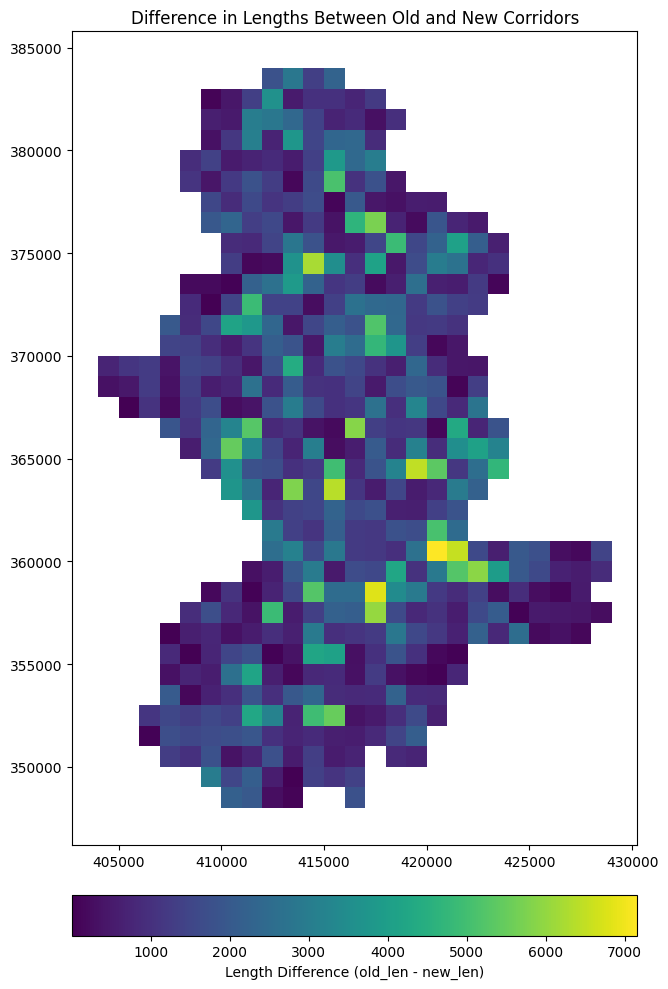

In [85]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
df['diff_len'] = df['diff_len'].abs()  # Make all values positive
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the size as needed

# Plot the DataFrame
df.plot(column='diff_len', ax=ax, cmap='viridis')  # Choose a colormap

# Create colorbar as a separate Axes
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.5)

# Generate colorbar
plt.colorbar(ax.collections[0], cax=cax, orientation='horizontal')
cax.set_xlabel("Length Difference (old_len - new_len)")

ax.set_title('Difference in Lengths Between Old and New Corridors')
plt.tight_layout()  # Adjust the layout to fit everything
plt.show()

Original CRS: EPSG:4326
Transformed to CRS: EPSG:4326


/tmp/ipykernel_4062/405778465.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf.geometry.centroid
/tmp/ipykernel_4062/405778465.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['hex_id'] = gdf.centroid.apply(lambda x: h3.geo_to_h3(x.y, x.x, resolution))


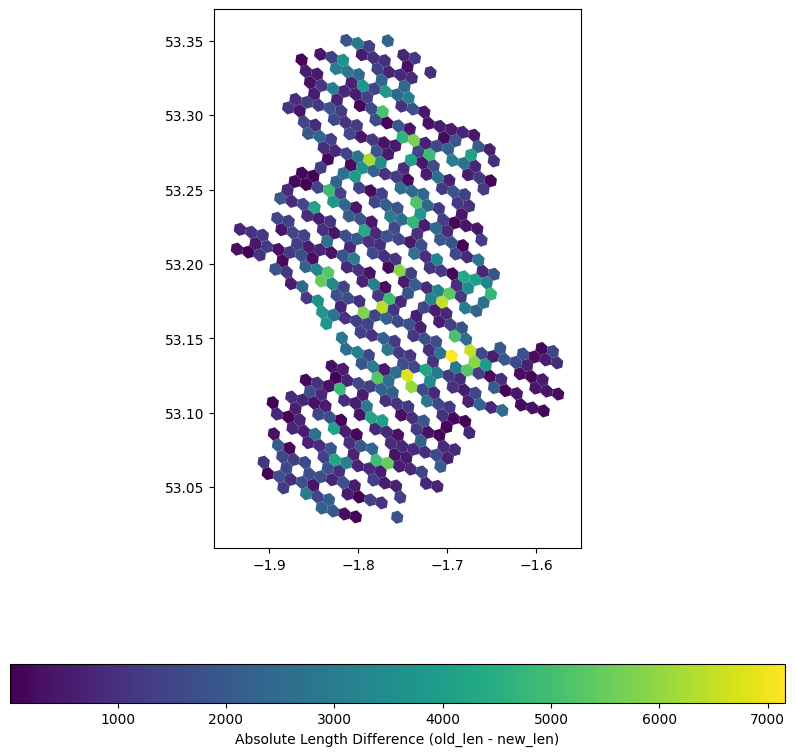

In [81]:
# Read in your grid GeoDataFrame and transform it to WGS84
gdf = gpd.read_file("../content/1950-corridors/osgrid_with_lengths.shp")
gdf = gdf.to_crs('EPSG:4326')  # Convert to WGS 84
gdf['diff_len'] = df['diff_len'].abs()
# Check the CRS and transform if necessary
print(f"Original CRS: {gdf.crs}")
target_crs = 'EPSG:4326'  # Set the target CRS to WGS84 for compatibility with h3
gdf = gdf.to_crs(target_crs)
print(f"Transformed to CRS: {gdf.crs}")

# Calculate the centroids of the squares in latitude and longitude
gdf['centroid'] = gdf.geometry.centroid

# Determine the hexbin ID for each centroid at the desired resolution
resolution = 8  # Adjust resolution, higher number means smaller hexagons

# Ensure you are using latitude (y) and longitude (x) in correct order for h3
gdf['hex_id'] = gdf.centroid.apply(lambda x: h3.geo_to_h3(x.y, x.x, resolution))

# Flatten the list of hexes and duplicate the data for each hex in the original grid square
rows = []
for idx, row in gdf.iterrows():
    new_row = row.to_dict()
    new_row['geometry'] = Polygon(h3.h3_to_geo_boundary(row['hex_id'], geo_json=True))
    rows.append(new_row)

# Create a new GeoDataFrame from the rows
hexbin_gdf = gpd.GeoDataFrame(rows, geometry='geometry', crs=target_crs)

# Plot the hexbin map
fig, ax = plt.subplots(figsize=(10, 10))
hexbin_gdf.plot(ax=ax, column='diff_len', cmap='viridis', legend=True,
                legend_kwds={'label': "Absolute Length Difference (old_len - new_len)",
                             'orientation': "horizontal"})

plt.show()

## Accuracy

In [ ]:
# clip the data to the masks

# Load the masks and data 
mask_gdf = gpd.read_file("../QGIS/masks/combined-mask.shp")
historic_gdf = gpd.read_file("../content/1950-corridors/1950-corridors.shp")
annotations_gdf = gpd.read_file("../content/labels/Walls.shp")

# This subtracts the mask from the historic and annotations datasets
diff_historic = gpd.overlay(historic_gdf, mask_gdf, how='difference')
diff_annotations = gpd.overlay(annotations_gdf, mask_gdf, how='difference')

# Optionally, save the clipped datasets for further analysis
# This subtracts the mask from the historic and annotations datasets
diff_historic.to_file("../content/1950-corridors/diff_1950_corridors.shp")
diff_annotations.to_file("../content/1950-corridors/diff_annotations_2023.shp")

### Proximity to Annotations

In [ ]:
# buffer
gdf_2023_buffered = diff_annotations.buffer(13)
# calc intersection
intersection = diff_historic.intersection(gdf_2023_buffered.unary_union)
# Subtract This Intersection from buffer-1950
difference = diff_historic.geometry - intersection.unary_union
# Any Area Remaining is F+
false_positives_area = difference.area.sum()  # This gives the total area of false positives
# save diff
difference.to_file("../content/1950-corridors/difference.shp")

In [ ]:
total_area_1950 = diff_historic.area.sum()
percent_false_positives = (false_positives_area / total_area_1950) * 100
print(f"Percentage of False Positives: {percent_false_positives}%")

In [ ]:
# Ensure diff_annotations is a GeoDataFrame
if not isinstance(diff_annotations, gpd.GeoDataFrame):
    diff_annotations = gpd.GeoDataFrame(diff_annotations)

# Ensure diff_historic is a GeoDataFrame
if not isinstance(diff_historic, gpd.GeoDataFrame):
    diff_historic = gpd.GeoDataFrame(diff_historic)

In [ ]:
# True+ TP
tp_intersection = gpd.overlay(diff_annotations, diff_historic, how='intersection')
true_positives_area = tp_intersection.area.sum()
print(f"Total Area of True Positives: {true_positives_area}")

In [ ]:
# True- TN
aoi_area = aoi.area.sum() if isinstance(aoi, gpd.GeoDataFrame) else aoi.area

# Subtract the union of predictions and annotations from the AOI to approximate TN
covered_area = diff_historic.unary_union.union(diff_annotations_buffered.unary_union).area
true_negatives_area = aoi_area - covered_area
print(f"Approximate Area of True Negatives: {true_negatives_area}")

In [ ]:
tp_intersection = diff_annotations.intersection(diff_historic.unary_union)
true_positives_area = tp_intersection.area.sum()
print(f"Total Area of True Positives: {true_positives_area}")